In [1]:
import llfbench as gym
import autogen
from opto.trace.nodes import node
from opto.trace.bundle import bundle
from opto.optimizers import FunctionOptimizer
from opto.trace.nodes import GRAPH
from llfbench.agents.llm import make_llm
from llfbench.agents.basic_ai_agent import BasicAIAgent
from llfbench.envs.poem.formal_poems import PoemUtil
from textwrap import dedent
from typing import List

In [2]:
def reformat(program_str: str):
    # remove empty lines and leading/trailing whitespaces
    return dedent(program_str).strip()

In [3]:
# The hierarchical poem generation task
env = gym.make('llf-poem-HierarchicalLineSyllableConstrainedPoem-v0') # alternative: Tanka; more general: LineSyllableConstrainedPoem

done = False
cumulative_reward = 0.0

system_prompt = BasicAIAgent.system_prompt
llm = make_llm("gpt-35-turbo", system_prompt=system_prompt)
agent = BasicAIAgent(llm, verbose=True)


/home/wanqiaoxu/miniconda3/envs/trace/lib/python3.9/site-packages/gymnasium/wrappers/compatibility.py:60: DeprecationWarning: WARN: The `gymnasium.make(..., apply_api_compatibility=...)` parameter is deprecated and will be removed in v1.0. Instead use `gymnasium.make('GymV21Environment-v0', env_name=...)` or `from shimmy import GymV21CompatibilityV0`
  logger.deprecation(


In [7]:
@bundle()
def check_length(text):
    "This is a function that checks the number of lines in a poem"
    return env.check_length(text)


@bundle()
def check_first_line(tup):
    "This is a function that checks the number of syllables in the first line of a poem"
    tup[1].append(env.check_syllables(0, tup[0]))
    return tup


@bundle()
def check_second_line(tup):
    "This is a function that checks the number of syllables in the second line of a poem"
    tup[1].append(env.check_syllables(1, tup[0]))
    return tup


@bundle()
def check_third_line(tup):
    "This is a function that checks the number of syllables in the third line of a poem"
    tup[1].append(env.check_syllables(2, tup[0]))
    return tup


# @bundle()
# def check_line(tup, i):
#     "This is a function that checks the number of syllables in the ith line of a poem"
#     tup[1].append(env.check_syllables(i - 1, tup[0]))
#     return tup


@bundle()
def act(prompt):
    "This is a function that asks the agent to act based on the prompt"
    agent.reset(prompt)
    observation, info = env.reset()
    return agent.act(observation['observation'], observation['feedback'])


@bundle()
def step(tup):
    "This is a function that takes a step in the environment"
    observation, reward, terminated, truncated, info = env.step(tup)
    return observation, reward, terminated, truncated, info

User:


History of feedbacks: None

Current observation: None

Instruction: Can you write me a poem?


Agent:

Thought: I should choose my words wisely and focus on setting a poetic tone.
Response: A poem to share, 
With a message to bear, 
Words that dance in air, 
And meaning beyond compare.

Action:

A poem to share, 
With a message to bear, 
Words that dance in air, 
And meaning beyond compare.



/home/wanqiaoxu/miniconda3/envs/trace/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.check_length to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.check_length` for environment variables or `env.get_wrapper_attr('check_length')` that will search the reminding wrappers.
  logger.warn(
/home/wanqiaoxu/miniconda3/envs/trace/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.check_syllables to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.check_syllables` for environment variables or `env.get_wrapper_attr('check_syllables')` that will search the reminding wrappers.
  logger.warn(


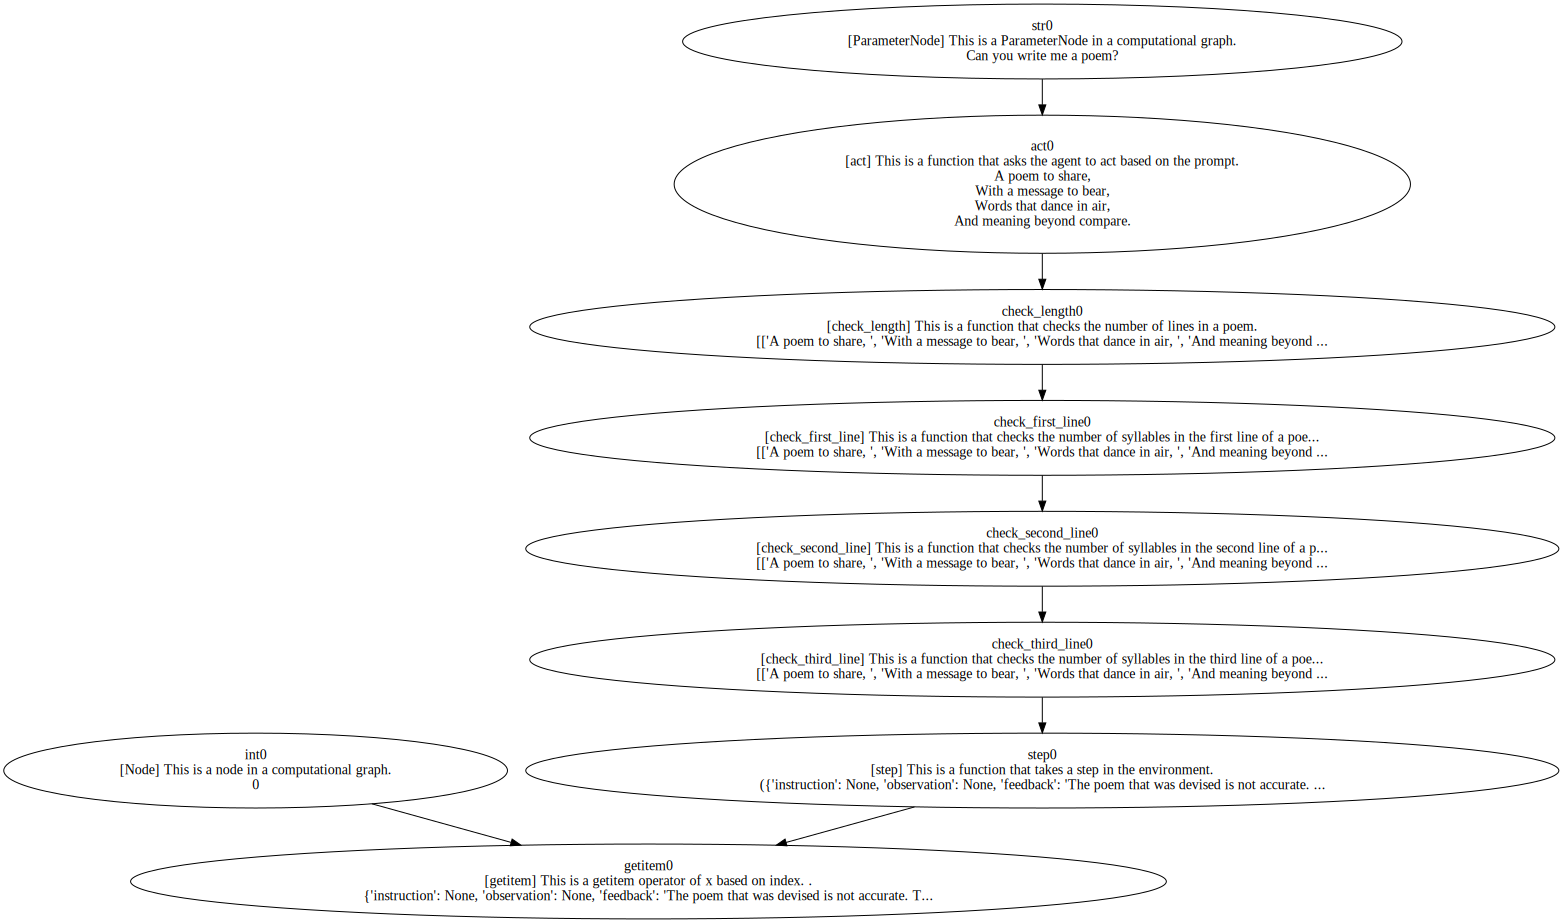

In [8]:
GRAPH.clear()
# The prompt to be optimized
prompt = node("Can you write me a poem?", trainable=True)

optimizer = FunctionOptimizer(
                            [prompt], 
                            config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"),
                            )
optimizer.objective = """You are a helpful assistant that wants to come up with instructions to a student to help
them write a poem that is satisfactory to a teacher's assignment.
The student's poem needs to satisfy the requirement of this assignment. """ + optimizer.default_objective

action = act(prompt)
# show the decision trace to the agent
check = check_length(action)
check = check_first_line(check)
check = check_second_line(check)
check = check_third_line(check)

observation, reward, terminated, truncated, info = step(check)

optimizer.zero_feedback()
# TODO: what should we call feedback on?
optimizer.backward(observation, observation['feedback'], visualize=True)


In [6]:
# history = [prompt.data]
# info = {}
# while not 'success' in info or not info['success']:
#     action = act(prompt)
#     check = check_length(action)
#     for i in range(3):
#         check = check_line(check, i)
#     observation, reward, terminated, truncated, info = step(check)
#     cumulative_reward += reward
#     done = terminated or truncated

#     optimizer.zero_feedback()
#     optimizer.backward(observation, observation['feedback'], visualize=True)
#     print(f"prompt: {prompt.data}, output: {observation['observation']}, feedback: {observation['feedback']}")
#     optimizer.step(verbose=True)
#     history.append(prompt.data)

# print(f'Episode reward: {cumulative_reward}')
# print(f'Final prompt: {prompt.data}')
# print('History')
# for i, h in enumerate(history):
#     print(f'{i}: {h}')
    